In [1]:
import numpy, pandas
import conntility
import os
import connalysis
import tqdm

from scipy.spatial import distance
from matplotlib import pyplot as plt


In [2]:
# Connectivity matrix to use
fn_mat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_funct_conmat_filtered_compressed.h5"
# Volume will be decomposed into volumes of this size
decomposition_sz = 200
# What are the horizontal axes of the volume? Decomposition will happen in this plane.
decomposition_plane = ["x", "z"]
# After decomposition, columns smaller than this will be discarded
min_column_sz = 500

# Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
mv_cv = numpy.array([[40**2, 0], [0, 40**2]]) 
# Up to this number of neurons will be sampled together
n_patch = 12
# The number of times the patch sampling procedure will be applied
# I.e. the number of sampled pairs will be <= n_patch * (n_patch - 1) * n_samples
n_samples = 25

M = conntility.ConnectivityMatrix.from_h5(fn_mat)

In [3]:
grps = conntility.circuit_models.neuron_groups.group_by_grid(M.vertices, decomposition_plane, decomposition_sz)
grps = grps.groupby("grid-subtarget")["node_ids"].apply(list)

Ms = []
for grp in grps:
    m = M.subpopulation(grp)
    if len(m) > min_column_sz:
        Ms.append(m)

Functions to patch sample and evaluate triads

In [4]:
P = 0.3
N = 1000
from connalysis.network.topology import triad_combinations
from scipy.stats import binom

num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
num_edge_per_non_triad = numpy.array([0, 1, 2])
non_triad_combinations = numpy.array([1, 6, 3])

p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

n_expected = N * (p_er / p_er.sum())
binom(N, (p_er / p_er.sum())).mean()

array([251.7563175 , 125.87815875, 125.87815875, 107.89556464,
       107.89556464, 107.89556464,  35.96518821,  23.12047814,
        46.24095628,  23.12047814,  23.12047814,  19.81755269,
         1.41553948])

In [5]:
col_slc = ["slice_x", "slice_y"]

def number_expected_er(P, N):
    from connalysis.network.topology import triad_combinations
    from scipy.stats import binom
    num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
    num_edge_per_non_triad = numpy.array([0, 1, 2])
    non_triad_combinations = numpy.array([1, 6, 3])

    p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
    p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
    assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

    distr_er = binom(N, (p_er / p_er.sum()))
    return distr_er.mean(), distr_er.std()

def sample_and_count_triads(m, mv_cv, n_patch=12, n_samples=25):
    counts = []
    sum_pairs = 0
    sum_connected = 0
    delta_rec = []
    delta_con = []
    delta_unc = []
    for _ in tqdm.tqdm(range(n_samples)):
        try:
            s = m.slice(numpy.random.rand() * numpy.pi, (numpy.random.rand() - 0.5) * 50, 150)
            s = s.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=["slice_x", "slice_y"])
            sum_pairs += (len(s) * (len(s) - 1))
            sum_connected += s.matrix.nnz
            counts.append(connalysis.network.topology.count_triads_fully_connected(s.matrix > 0, return_normalized=False))
            D = s.vertices[col_slc].values.reshape((-1, 1, 2)) - s.vertices[col_slc].values.reshape((1, -1, 2))
            delta_rec.append(D[(s.array > 0) & (s.array.transpose() > 0)])
            delta_con.append(D[(s.array > 0) & (s.array.transpose() == 0)])
            delta_unc.append(D[(s.array == 0)])
        except:
            pass
    P = sum_connected / sum_pairs
    deltas = {"reciprocal": delta_rec, "connected": delta_con, "unconnected": delta_unc}
    counts = numpy.vstack(counts).sum(axis=0)
    return counts, P, deltas


EXECUTE!

In [6]:
all_counts = []
all_er = []
all_deltas = []
for m in Ms:
    counts, P, deltas = sample_and_count_triads(m, mv_cv)
    count_er_mn, count_er_sd = number_expected_er(P, counts.sum())
    all_counts.append((counts - count_er_mn) / count_er_sd)
    all_deltas.append(deltas)

all_counts = pandas.DataFrame(all_counts,
                 index=pandas.RangeIndex(len(all_counts), name="subvolume"),
                 columns=pandas.RangeIndex(13, name="motif"))

 24%|██▍       | 6/25 [00:00<00:00, 24.47it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001482248306274414
Found 161 connected triads
Time spent classifying triads: 0.014796018600463867
Testing 66 potential triadic pairs
Time spent finding triads: 0.001314401626586914
Found 173 connected triads
Time spent classifying triads: 0.0066375732421875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012564659118652344
Found 147 connected triads
Time spent classifying triads: 0.005670070648193359
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012543201446533203
Found 165 connected triads
Time spent classifying triads: 0.006339550018310547
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011739730834960938
Found 113 connected triads
Time spent classifying triads: 0.004518985748291016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013692378997802734
Found 198 connected triads
Time spent classifying triads: 0.0075473785400390625


 48%|████▊     | 12/25 [00:00<00:00, 24.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013251304626464844
Found 169 connected triads
Time spent classifying triads: 0.013069629669189453
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013341903686523438
Found 187 connected triads
Time spent classifying triads: 0.007151603698730469
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013256072998046875
Found 185 connected triads
Time spent classifying triads: 0.0070302486419677734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013263225555419922
Found 185 connected triads
Time spent classifying triads: 0.006996870040893555
Testing 66 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 152 connected triads
Time spent classifying triads: 0.006273031234741211
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011951923370361328
Found 130 connected triads
Time spent classifying triads: 0.0049686431884765625


 72%|███████▏  | 18/25 [00:00<00:00, 25.00it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001283884048461914
Found 153 connected triads
Time spent classifying triads: 0.010906219482421875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012884140014648438
Found 167 connected triads
Time spent classifying triads: 0.00639653205871582
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013179779052734375
Found 190 connected triads
Time spent classifying triads: 0.0072591304779052734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012469291687011719
Found 165 connected triads
Time spent classifying triads: 0.006310939788818359
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012929439544677734
Found 162 connected triads
Time spent classifying triads: 0.006193399429321289
Testing 66 potential triadic pairs
Time spent finding triads: 0.001287221908569336
Found 184 connected triads
Time spent classifying triads: 0.007013082504272461


 96%|█████████▌| 24/25 [00:00<00:00, 25.26it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012907981872558594
Found 153 connected triads
Time spent classifying triads: 0.013986825942993164
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011980533599853516
Found 129 connected triads
Time spent classifying triads: 0.004953145980834961
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013039112091064453
Found 176 connected triads
Time spent classifying triads: 0.006699323654174805
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013098716735839844
Found 180 connected triads
Time spent classifying triads: 0.0068967342376708984
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 124 connected triads
Time spent classifying triads: 0.0047054290771484375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012145042419433594
Found 138 connected triads
Time spent classifying triads: 0.005257606506347656


100%|██████████| 25/25 [00:01<00:00, 24.67it/s]


Testing 59 potential triadic pairs
Time spent finding triads: 0.0011723041534423828
Found 105 connected triads
Time spent classifying triads: 0.009634017944335938


 12%|█▏        | 3/25 [00:00<00:00, 24.60it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012726783752441406
Found 141 connected triads
Time spent classifying triads: 0.012968301773071289
Testing 66 potential triadic pairs
Time spent finding triads: 0.001257181167602539
Found 162 connected triads
Time spent classifying triads: 0.006154775619506836
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011408329010009766
Found 117 connected triads
Time spent classifying triads: 0.004492282867431641
Testing 66 potential triadic pairs
Time spent finding triads: 0.001340627670288086
Found 146 connected triads
Time spent classifying triads: 0.005543231964111328
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012335777282714844
Found 157 connected triads
Time spent classifying triads: 0.009170293807983398


 24%|██▍       | 6/25 [00:00<00:00, 24.91it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001047372817993164
Found 67 connected triads
Time spent classifying triads: 0.006197929382324219


 36%|███▌      | 9/25 [00:00<00:00, 24.72it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012409687042236328
Found 135 connected triads
Time spent classifying triads: 0.01240992546081543
Testing 66 potential triadic pairs
Time spent finding triads: 0.001219034194946289
Found 138 connected triads
Time spent classifying triads: 0.005265235900878906
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012607574462890625
Found 162 connected triads
Time spent classifying triads: 0.0061571598052978516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013020038604736328
Found 179 connected triads
Time spent classifying triads: 0.005897045135498047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012483596801757812
Found 165 connected triads
Time spent classifying triads: 0.006201267242431641
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013043880462646484
Found 163 connected triads
Time spent classifying triads: 0.014919281005859375


 60%|██████    | 15/25 [00:00<00:00, 24.28it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001386880874633789
Found 196 connected triads
Time spent classifying triads: 0.01794147491455078
Testing 61 potential triadic pairs
Time spent finding triads: 0.0010852813720703125
Found 79 connected triads
Time spent classifying triads: 0.003064393997192383
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011777877807617188
Found 128 connected triads
Time spent classifying triads: 0.004901409149169922
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012371540069580078
Found 152 connected triads
Time spent classifying triads: 0.005754232406616211
Testing 66 potential triadic pairs
Time spent finding triads: 0.001262664794921875
Found 165 connected triads
Time spent classifying triads: 0.006253719329833984


 72%|███████▏  | 18/25 [00:00<00:00, 24.53it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011587142944335938
Found 99 connected triads
Time spent classifying triads: 0.009064197540283203


 84%|████████▍ | 21/25 [00:00<00:00, 24.49it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013408660888671875
Found 176 connected triads
Time spent classifying triads: 0.016132831573486328
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012209415435791016
Found 127 connected triads
Time spent classifying triads: 0.0064318180084228516
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009865760803222656
Found 53 connected triads
Time spent classifying triads: 0.0020830631256103516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012257099151611328
Found 154 connected triads
Time spent classifying triads: 0.00583338737487793
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012271404266357422
Found 137 connected triads


 96%|█████████▌| 24/25 [00:00<00:00, 24.64it/s]

Time spent classifying triads: 0.005973100662231445
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012369155883789062
Found 152 connected triads
Time spent classifying triads: 0.0057942867279052734


100%|██████████| 25/25 [00:01<00:00, 24.34it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 131 connected triads
Time spent classifying triads: 0.012011051177978516


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011782646179199219
Found 102 connected triads
Time spent classifying triads: 0.009404182434082031
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013515949249267578
Found 181 connected triads
Time spent classifying triads: 0.006924867630004883


 12%|█▏        | 3/25 [00:00<00:00, 23.77it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.002142667770385742
Found 116 connected triads
Time spent classifying triads: 0.010558605194091797
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010399818420410156
Found 68 connected triads
Time spent classifying triads: 0.002649068832397461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013501644134521484
Found 192 connected triads
Time spent classifying triads: 0.013556480407714844
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013170242309570312
Found 167 connected triads
Time spent classifying triads: 0.015311241149902344


 24%|██▍       | 6/25 [00:00<00:00, 23.33it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012216567993164062
Found 127 connected triads
Time spent classifying triads: 0.011708259582519531


 36%|███▌      | 9/25 [00:00<00:00, 23.10it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013556480407714844
Found 178 connected triads
Time spent classifying triads: 0.014061212539672852
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012240409851074219
Found 147 connected triads
Time spent classifying triads: 0.0055735111236572266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012712478637695312
Found 168 connected triads
Time spent classifying triads: 0.006424427032470703
Testing 66 potential triadic pairs
Time spent finding triads: 0.001956939697265625
Found 113 connected triads
Time spent classifying triads: 0.010295391082763672
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011246204376220703
Found 92 connected triads
Time spent classifying triads: 0.004449605941772461


 48%|████▊     | 12/25 [00:00<00:00, 23.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013632774353027344
Found 180 connected triads
Time spent classifying triads: 0.014295578002929688


 60%|██████    | 15/25 [00:00<00:00, 23.24it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014100074768066406
Found 199 connected triads
Time spent classifying triads: 0.018218517303466797
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010907649993896484
Found 83 connected triads
Time spent classifying triads: 0.003198385238647461
Testing 66 potential triadic pairs
Time spent finding triads: 0.002202749252319336
Found 124 connected triads
Time spent classifying triads: 0.011362075805664062
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012195110321044922
Found 137 connected triads
Time spent classifying triads: 0.005264997482299805
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 159 connected triads
Time spent classifying triads: 0.012073040008544922


 72%|███████▏  | 18/25 [00:00<00:00, 23.34it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012307167053222656
Found 131 connected triads
Time spent classifying triads: 0.009435176849365234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0015232563018798828
Found 209 connected triads
Time spent classifying triads: 0.014743566513061523


 84%|████████▍ | 21/25 [00:00<00:00, 23.34it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0014836788177490234
Found 30 connected triads
Time spent classifying triads: 0.002172231674194336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011746883392333984
Found 111 connected triads
Time spent classifying triads: 0.00421595573425293
Testing 62 potential triadic pairs
Time spent finding triads: 0.001132965087890625
Found 100 connected triads
Time spent classifying triads: 0.0038568973541259766
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012502670288085938
Found 155 connected triads
Time spent classifying triads: 0.006933450698852539


 96%|█████████▌| 24/25 [00:01<00:00, 24.32it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013048648834228516
Found 160 connected triads
Time spent classifying triads: 0.014747142791748047


 12%|█▏        | 3/25 [00:00<00:00, 24.70it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0012884140014648438
Found 107 connected triads
Time spent classifying triads: 0.00985574722290039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012471675872802734
Found 156 connected triads
Time spent classifying triads: 0.0059015750885009766
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011754035949707031
Found 113 connected triads
Time spent classifying triads: 0.0043337345123291016
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011661052703857422
Found 112 connected triads
Time spent classifying triads: 0.004285573959350586
Testing 66 potential triadic pairs
Time spent finding triads: 0.0022728443145751953
Found 143 connected triads
Time spent classifying triads: 0.013028621673583984
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011696815490722656
Found 121 connected triads


 36%|███▌      | 9/25 [00:00<00:00, 24.17it/s]

Time spent classifying triads: 0.009665966033935547
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011301040649414062
Found 93 connected triads
Time spent classifying triads: 0.0036039352416992188
Testing 63 potential triadic pairs
Time spent finding triads: 0.0013341903686523438
Found 141 connected triads
Time spent classifying triads: 0.005373477935791016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012450218200683594
Found 161 connected triads
Time spent classifying triads: 0.006171703338623047
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011334419250488281
Found 108 connected triads
Time spent classifying triads: 0.004340171813964844
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012331008911132812
Found 123 connected triads
Time spent classifying triads: 0.009878396987915039


 60%|██████    | 15/25 [00:00<00:00, 23.98it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012116432189941406
Found 118 connected triads
Time spent classifying triads: 0.010433673858642578
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012764930725097656
Found 171 connected triads
Time spent classifying triads: 0.00647425651550293
Testing 66 potential triadic pairs
Time spent finding triads: 0.00130462646484375
Found 180 connected triads
Time spent classifying triads: 0.015377521514892578
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009453296661376953
Found 41 connected triads
Time spent classifying triads: 0.0016422271728515625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012712478637695312
Found 158 connected triads
Time spent classifying triads: 0.014678001403808594


 84%|████████▍ | 21/25 [00:00<00:00, 24.04it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011944770812988281
Found 118 connected triads
Time spent classifying triads: 0.009435892105102539
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013196468353271484
Found 185 connected triads
Time spent classifying triads: 0.007134437561035156
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011816024780273438
Found 124 connected triads
Time spent classifying triads: 0.004751443862915039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011920928955078125
Found 125 connected triads
Time spent classifying triads: 0.004787921905517578
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010838508605957031
Found 92 connected triads
Time spent classifying triads: 0.0035812854766845703
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012629032135009766
Found 142 connected triads


100%|██████████| 25/25 [00:01<00:00, 23.73it/s]


Time spent classifying triads: 0.013408422470092773
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012466907501220703
Found 148 connected triads
Time spent classifying triads: 0.01114964485168457
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011701583862304688
Found 108 connected triads
Time spent classifying triads: 0.004162788391113281
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012264251708984375
Found 140 connected triads
Time spent classifying triads: 0.005323886871337891


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012705326080322266
Found 155 connected triads
Time spent classifying triads: 0.014235734939575195


 16%|█▌        | 4/25 [00:00<00:01, 16.54it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014050006866455078
Found 191 connected triads
Time spent classifying triads: 0.01747894287109375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013048648834228516
Found 180 connected triads
Time spent classifying triads: 0.006913185119628906
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012409687042236328
Found 150 connected triads
Time spent classifying triads: 0.005738496780395508
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012242794036865234
Found 106 connected triads
Time spent classifying triads: 0.00981450080871582


 32%|███▏      | 8/25 [00:00<00:00, 17.20it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013706684112548828
Found 173 connected triads
Time spent classifying triads: 0.015819072723388672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013315677642822266
Found 174 connected triads
Time spent classifying triads: 0.006633758544921875
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011777877807617188
Found 115 connected triads
Time spent classifying triads: 0.0044155120849609375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012607574462890625
Found 129 connected triads
Time spent classifying triads: 0.011846780776977539


 48%|████▊     | 12/25 [00:00<00:00, 17.65it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001394510269165039
Found 193 connected triads
Time spent classifying triads: 0.011480331420898438
Testing 66 potential triadic pairs
Time spent finding triads: 0.001220703125
Found 137 connected triads
Time spent classifying triads: 0.0052449703216552734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012695789337158203
Found 165 connected triads
Time spent classifying triads: 0.006307125091552734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 124 connected triads
Time spent classifying triads: 0.011388301849365234


 64%|██████▍   | 16/25 [00:00<00:00, 17.45it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013260841369628906
Found 150 connected triads
Time spent classifying triads: 0.013844490051269531
Testing 64 potential triadic pairs
Time spent finding triads: 0.001226186752319336
Found 137 connected triads
Time spent classifying triads: 0.005216360092163086
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011861324310302734
Found 116 connected triads
Time spent classifying triads: 0.004457235336303711
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011832714080810547
Found 105 connected triads
Time spent classifying triads: 0.00747370719909668


 80%|████████  | 20/25 [00:01<00:00, 17.62it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012714862823486328
Found 134 connected triads
Time spent classifying triads: 0.01232290267944336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 152 connected triads
Time spent classifying triads: 0.005796670913696289
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011463165283203125
Found 101 connected triads
Time spent classifying triads: 0.003912210464477539
Testing 65 potential triadic pairs
Time spent finding triads: 0.00122833251953125
Found 113 connected triads
Time spent classifying triads: 0.010568857192993164


 96%|█████████▌| 24/25 [00:01<00:00, 18.03it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012269020080566406
Found 107 connected triads
Time spent classifying triads: 0.009830951690673828
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011854171752929688
Found 121 connected triads
Time spent classifying triads: 0.0046389102935791016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012314319610595703
Found 140 connected triads
Time spent classifying triads: 0.005362272262573242


100%|██████████| 25/25 [00:01<00:00, 17.26it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.001413106918334961
Found 183 connected triads
Time spent classifying triads: 0.01681041717529297


  8%|▊         | 2/25 [00:00<00:01, 16.83it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013427734375
Found 168 connected triads
Time spent classifying triads: 0.015391349792480469
Testing 66 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 147 connected triads
Time spent classifying triads: 0.0057032108306884766
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012204647064208984
Found 140 connected triads
Time spent classifying triads: 0.0053746700286865234


 16%|█▌        | 4/25 [00:00<00:01, 17.19it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012445449829101562
Found 114 connected triads
Time spent classifying triads: 0.010541677474975586


 24%|██▍       | 6/25 [00:00<00:01, 16.86it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012395381927490234
Found 123 connected triads
Time spent classifying triads: 0.011305809020996094
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012748241424560547
Found 153 connected triads
Time spent classifying triads: 0.005820035934448242
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011951923370361328
Found 135 connected triads
Time spent classifying triads: 0.005160331726074219


 32%|███▏      | 8/25 [00:00<00:00, 17.03it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012526512145996094
Found 125 connected triads
Time spent classifying triads: 0.011461973190307617


 40%|████      | 10/25 [00:00<00:00, 17.33it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.00113677978515625
Found 83 connected triads
Time spent classifying triads: 0.007651805877685547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012292861938476562
Found 151 connected triads
Time spent classifying triads: 0.005789995193481445
Testing 66 potential triadic pairs
Time spent finding triads: 0.001232147216796875
Found 140 connected triads
Time spent classifying triads: 0.005345582962036133


 48%|████▊     | 12/25 [00:00<00:00, 17.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013778209686279297
Found 173 connected triads
Time spent classifying triads: 0.01589345932006836


 56%|█████▌    | 14/25 [00:00<00:00, 16.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013020038604736328
Found 164 connected triads
Time spent classifying triads: 0.015118122100830078
Testing 66 potential triadic pairs
Time spent finding triads: 0.001337289810180664
Found 192 connected triads
Time spent classifying triads: 0.0073108673095703125
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011675357818603516
Found 117 connected triads
Time spent classifying triads: 0.004527091979980469


 64%|██████▍   | 16/25 [00:00<00:00, 16.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013880729675292969
Found 182 connected triads
Time spent classifying triads: 0.016708850860595703


 72%|███████▏  | 18/25 [00:01<00:00, 16.74it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001329660415649414
Found 152 connected triads
Time spent classifying triads: 0.008740425109863281
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012357234954833984
Found 141 connected triads
Time spent classifying triads: 0.00535273551940918
Testing 62 potential triadic pairs
Time spent finding triads: 0.001154184341430664
Found 104 connected triads
Time spent classifying triads: 0.004063844680786133


 80%|████████  | 20/25 [00:01<00:00, 16.95it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012621879577636719
Found 129 connected triads
Time spent classifying triads: 0.011813640594482422


 88%|████████▊ | 22/25 [00:01<00:00, 17.32it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.001148223876953125
Found 80 connected triads
Time spent classifying triads: 0.007372856140136719
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011570453643798828
Found 109 connected triads
Time spent classifying triads: 0.0042095184326171875
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012297630310058594
Found 132 connected triads
Time spent classifying triads: 0.005084037780761719


 96%|█████████▌| 24/25 [00:01<00:00, 17.29it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012843608856201172
Found 141 connected triads
Time spent classifying triads: 0.01300191879272461


100%|██████████| 25/25 [00:01<00:00, 17.00it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0012943744659423828
Found 154 connected triads
Time spent classifying triads: 0.014104843139648438


 12%|█▏        | 3/25 [00:00<00:00, 25.73it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.001088857650756836
Found 66 connected triads
Time spent classifying triads: 0.006117582321166992
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011608600616455078
Found 109 connected triads
Time spent classifying triads: 0.004190206527709961
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012259483337402344
Found 142 connected triads
Time spent classifying triads: 0.005426168441772461
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011348724365234375
Found 80 connected triads
Time spent classifying triads: 0.007424116134643555
Testing 66 potential triadic pairs
Time spent finding triads: 0.002194643020629883
Found 112 connected triads
Time spent classifying triads: 0.010245084762573242
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012581348419189453
Found 158 connected triads
Time spent classifying triads: 0.010426998138427734


 24%|██▍       | 6/25 [00:00<00:00, 23.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013096332550048828
Found 155 connected triads
Time spent classifying triads: 0.014229774475097656
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012204647064208984
Found 140 connected triads
Time spent classifying triads: 0.005357503890991211


 36%|███▌      | 9/25 [00:00<00:00, 23.38it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010097026824951172
Found 45 connected triads
Time spent classifying triads: 0.004205226898193359
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012238025665283203
Found 121 connected triads
Time spent classifying triads: 0.011116266250610352
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013206005096435547
Found 187 connected triads
Time spent classifying triads: 0.0072062015533447266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012712478637695312
Found 160 connected triads
Time spent classifying triads: 0.014696836471557617


 48%|████▊     | 12/25 [00:00<00:00, 22.50it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012142658233642578
Found 129 connected triads
Time spent classifying triads: 0.011842012405395508
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011603832244873047
Found 90 connected triads
Time spent classifying triads: 0.008325338363647461


 60%|██████    | 15/25 [00:00<00:00, 22.05it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001268148422241211
Found 141 connected triads
Time spent classifying triads: 0.01294398307800293
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012936592102050781
Found 169 connected triads
Time spent classifying triads: 0.006484031677246094
Testing 59 potential triadic pairs
Time spent finding triads: 0.0010859966278076172
Found 87 connected triads
Time spent classifying triads: 0.003359079360961914


 72%|███████▏  | 18/25 [00:00<00:00, 22.66it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012967586517333984
Found 97 connected triads
Time spent classifying triads: 0.0084686279296875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 148 connected triads
Time spent classifying triads: 0.013529300689697266


 84%|████████▍ | 21/25 [00:00<00:00, 22.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012738704681396484
Found 158 connected triads
Time spent classifying triads: 0.0072209835052490234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012676715850830078
Found 169 connected triads
Time spent classifying triads: 0.006470203399658203
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012164115905761719
Found 145 connected triads
Time spent classifying triads: 0.005529165267944336
Testing 64 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 159 connected triads
Time spent classifying triads: 0.014499425888061523


 96%|█████████▌| 24/25 [00:01<00:00, 22.24it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012478828430175781
Found 144 connected triads
Time spent classifying triads: 0.013257980346679688


100%|██████████| 25/25 [00:01<00:00, 22.69it/s]


Testing 44 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 48 connected triads
Time spent classifying triads: 0.004483938217163086


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012793540954589844
Found 147 connected triads
Time spent classifying triads: 0.012821435928344727


  8%|▊         | 2/25 [00:00<00:01, 16.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0021927356719970703
Found 144 connected triads
Time spent classifying triads: 0.007094860076904297
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013020038604736328
Found 150 connected triads
Time spent classifying triads: 0.013758182525634766


 16%|█▌        | 4/25 [00:00<00:01, 16.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013632774353027344
Found 170 connected triads
Time spent classifying triads: 0.01508021354675293
Testing 64 potential triadic pairs
Time spent finding triads: 0.001260995864868164
Found 136 connected triads
Time spent classifying triads: 0.012511491775512695


 24%|██▍       | 6/25 [00:00<00:01, 16.39it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 131 connected triads
Time spent classifying triads: 0.009591102600097656
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012822151184082031
Found 146 connected triads
Time spent classifying triads: 0.008854389190673828


 32%|███▏      | 8/25 [00:00<00:01, 16.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012600421905517578
Found 133 connected triads
Time spent classifying triads: 0.012231111526489258
Testing 41 potential triadic pairs
Time spent finding triads: 0.001049041748046875
Found 62 connected triads
Time spent classifying triads: 0.005750894546508789


 40%|████      | 10/25 [00:00<00:00, 16.81it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013053417205810547
Found 148 connected triads
Time spent classifying triads: 0.013582229614257812
Testing 61 potential triadic pairs
Time spent finding triads: 0.0013053417205810547
Found 147 connected triads
Time spent classifying triads: 0.013506889343261719


 48%|████▊     | 12/25 [00:00<00:00, 16.56it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012688636779785156
Found 144 connected triads
Time spent classifying triads: 0.012300252914428711
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012857913970947266
Found 136 connected triads
Time spent classifying triads: 0.012606143951416016


 56%|█████▌    | 14/25 [00:00<00:00, 16.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001257181167602539
Found 129 connected triads
Time spent classifying triads: 0.01192164421081543
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013179779052734375
Found 156 connected triads
Time spent classifying triads: 0.014364957809448242


 64%|██████▍   | 16/25 [00:00<00:00, 15.88it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012793540954589844
Found 128 connected triads
Time spent classifying triads: 0.011778116226196289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013418197631835938
Found 162 connected triads
Time spent classifying triads: 0.014861345291137695


 72%|███████▏  | 18/25 [00:01<00:00, 15.99it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001285552978515625
Found 143 connected triads
Time spent classifying triads: 0.013149738311767578
Testing 66 potential triadic pairs
Time spent finding triads: 0.001394510269165039
Found 189 connected triads
Time spent classifying triads: 0.017304182052612305


 80%|████████  | 20/25 [00:01<00:00, 15.98it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013689994812011719
Found 183 connected triads
Time spent classifying triads: 0.012472867965698242
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012259483337402344
Found 115 connected triads
Time spent classifying triads: 0.005906581878662109


 88%|████████▊ | 22/25 [00:01<00:00, 16.70it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.00130462646484375
Found 145 connected triads
Time spent classifying triads: 0.00691986083984375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013773441314697266
Found 168 connected triads
Time spent classifying triads: 0.015402793884277344


 96%|█████████▌| 24/25 [00:01<00:00, 16.56it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012621879577636719
Found 137 connected triads
Time spent classifying triads: 0.010393142700195312


100%|██████████| 25/25 [00:01<00:00, 16.38it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0013384819030761719
Found 168 connected triads
Time spent classifying triads: 0.013518333435058594


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012462139129638672
Found 111 connected triads
Time spent classifying triads: 0.010221004486083984


  8%|▊         | 2/25 [00:00<00:01, 16.37it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012350082397460938
Found 118 connected triads
Time spent classifying triads: 0.010897636413574219
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013499259948730469
Found 172 connected triads
Time spent classifying triads: 0.01574993133544922


 16%|█▌        | 4/25 [00:00<00:01, 15.28it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013668537139892578
Found 180 connected triads
Time spent classifying triads: 0.016641855239868164
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012035369873046875
Found 90 connected triads
Time spent classifying triads: 0.008344650268554688


 24%|██▍       | 6/25 [00:00<00:01, 15.63it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012919902801513672
Found 152 connected triads
Time spent classifying triads: 0.013952016830444336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 154 connected triads
Time spent classifying triads: 0.012462615966796875


 32%|███▏      | 8/25 [00:00<00:01, 16.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012669563293457031
Found 137 connected triads
Time spent classifying triads: 0.005972623825073242
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012323856353759766
Found 118 connected triads
Time spent classifying triads: 0.010867118835449219


 40%|████      | 10/25 [00:00<00:00, 16.10it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012500286102294922
Found 123 connected triads
Time spent classifying triads: 0.011342763900756836
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011010169982910156
Found 75 connected triads
Time spent classifying triads: 0.0069501399993896484


 48%|████▊     | 12/25 [00:00<00:00, 15.93it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001424551010131836
Found 195 connected triads
Time spent classifying triads: 0.01786971092224121
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012404918670654297
Found 117 connected triads
Time spent classifying triads: 0.010795116424560547


 56%|█████▌    | 14/25 [00:00<00:00, 16.03it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012764930725097656
Found 130 connected triads
Time spent classifying triads: 0.0065305233001708984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013759136199951172
Found 173 connected triads
Time spent classifying triads: 0.015856027603149414


 64%|██████▍   | 16/25 [00:01<00:00, 15.72it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012369155883789062
Found 112 connected triads
Time spent classifying triads: 0.010317564010620117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013012886047363281
Found 145 connected triads
Time spent classifying triads: 0.013352155685424805


 72%|███████▏  | 18/25 [00:01<00:00, 15.62it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013592243194580078
Found 169 connected triads
Time spent classifying triads: 0.015479087829589844
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011725425720214844
Found 97 connected triads
Time spent classifying triads: 0.008929967880249023


 80%|████████  | 20/25 [00:01<00:00, 15.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001299142837524414
Found 151 connected triads
Time spent classifying triads: 0.013918399810791016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014209747314453125
Found 196 connected triads
Time spent classifying triads: 0.01808762550354004


 88%|████████▊ | 22/25 [00:01<00:00, 15.60it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012538433074951172
Found 132 connected triads
Time spent classifying triads: 0.012094736099243164
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012278556823730469
Found 121 connected triads
Time spent classifying triads: 0.011194705963134766


 96%|█████████▌| 24/25 [00:01<00:00, 15.79it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012464523315429688
Found 120 connected triads
Time spent classifying triads: 0.011060953140258789


100%|██████████| 25/25 [00:01<00:00, 15.79it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0013039112091064453
Found 150 connected triads
Time spent classifying triads: 0.013827800750732422


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011074542999267578
Found 75 connected triads
Time spent classifying triads: 0.006945371627807617


  8%|▊         | 2/25 [00:00<00:01, 16.27it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013370513916015625
Found 162 connected triads
Time spent classifying triads: 0.014878988265991211
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013613700866699219
Found 154 connected triads


 16%|█▌        | 4/25 [00:00<00:01, 12.46it/s]

Time spent classifying triads: 0.014602184295654297
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011742115020751953
Found 108 connected triads
Time spent classifying triads: 0.00415802001953125


 24%|██▍       | 6/25 [00:00<00:01, 14.49it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012354850769042969
Found 101 connected triads
Time spent classifying triads: 0.009301900863647461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013120174407958984
Found 169 connected triads
Time spent classifying triads: 0.006466388702392578


 32%|███▏      | 8/25 [00:00<00:01, 15.76it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001188039779663086
Found 95 connected triads
Time spent classifying triads: 0.008762121200561523
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012254714965820312
Found 130 connected triads
Time spent classifying triads: 0.0050029754638671875


 40%|████      | 10/25 [00:00<00:00, 16.72it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014295578002929688
Found 191 connected triads
Time spent classifying triads: 0.00794529914855957
Testing 66 potential triadic pairs
Time spent finding triads: 0.001291036605834961
Found 172 connected triads
Time spent classifying triads: 0.006568193435668945


 48%|████▊     | 12/25 [00:00<00:00, 16.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013730525970458984
Found 187 connected triads
Time spent classifying triads: 0.017108678817749023
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011627674102783203
Found 113 connected triads
Time spent classifying triads: 0.004358768463134766


 56%|█████▌    | 14/25 [00:00<00:00, 16.88it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013141632080078125
Found 160 connected triads
Time spent classifying triads: 0.014679431915283203
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013113021850585938
Found 185 connected triads
Time spent classifying triads: 0.007005453109741211


 64%|██████▍   | 16/25 [00:00<00:00, 17.21it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011823177337646484
Found 89 connected triads
Time spent classifying triads: 0.008193254470825195
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 149 connected triads
Time spent classifying triads: 0.005656719207763672


 72%|███████▏  | 18/25 [00:01<00:00, 17.36it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001275777816772461
Found 145 connected triads
Time spent classifying triads: 0.013308048248291016
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 107 connected triads
Time spent classifying triads: 0.004124641418457031


 80%|████████  | 20/25 [00:01<00:00, 17.49it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001238107681274414
Found 107 connected triads
Time spent classifying triads: 0.009843826293945312
Testing 66 potential triadic pairs
Time spent finding triads: 0.001241445541381836
Found 145 connected triads
Time spent classifying triads: 0.005540132522583008


 88%|████████▊ | 22/25 [00:01<00:00, 17.79it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012660026550292969
Found 126 connected triads
Time spent classifying triads: 0.007276058197021484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012812614440917969
Found 162 connected triads
Time spent classifying triads: 0.006140708923339844


 96%|█████████▌| 24/25 [00:01<00:00, 18.05it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011487007141113281
Found 82 connected triads
Time spent classifying triads: 0.006065845489501953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012764930725097656
Found 155 connected triads
Time spent classifying triads: 0.005878925323486328


100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


Testing 64 potential triadic pairs
Time spent finding triads: 0.0012035369873046875
Found 108 connected triads
Time spent classifying triads: 0.00993204116821289


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014357566833496094
Found 179 connected triads
Time spent classifying triads: 0.016408681869506836


  8%|▊         | 2/25 [00:00<00:01, 19.58it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001245737075805664
Found 127 connected triads
Time spent classifying triads: 0.011622190475463867
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011682510375976562
Found 125 connected triads
Time spent classifying triads: 0.004924774169921875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012674331665039062
Found 154 connected triads
Time spent classifying triads: 0.005896806716918945


 20%|██        | 5/25 [00:00<00:00, 22.26it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012521743774414062
Found 122 connected triads
Time spent classifying triads: 0.011180400848388672
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011966228485107422
Found 116 connected triads
Time spent classifying triads: 0.01061391830444336


 32%|███▏      | 8/25 [00:00<00:00, 21.97it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012552738189697266
Found 140 connected triads
Time spent classifying triads: 0.01278066635131836
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011839866638183594
Found 112 connected triads
Time spent classifying triads: 0.00433802604675293
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012385845184326172
Found 151 connected triads
Time spent classifying triads: 0.005793571472167969
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012421607971191406
Found 135 connected triads
Time spent classifying triads: 0.012348413467407227


 44%|████▍     | 11/25 [00:00<00:00, 22.16it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012257099151611328
Found 116 connected triads
Time spent classifying triads: 0.01065373420715332


 56%|█████▌    | 14/25 [00:00<00:00, 22.62it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013077259063720703
Found 154 connected triads
Time spent classifying triads: 0.014104366302490234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 121 connected triads
Time spent classifying triads: 0.004630565643310547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012519359588623047
Found 157 connected triads
Time spent classifying triads: 0.005990266799926758
Testing 66 potential triadic pairs
Time spent finding triads: 0.001312255859375
Found 168 connected triads
Time spent classifying triads: 0.010867595672607422
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011992454528808594
Found 108 connected triads
Time spent classifying triads: 0.005472660064697266
Testing 66 potential triadic pairs
Time spent finding triads: 0.001287221908569336
Found 179 connected triads


 68%|██████▊   | 17/25 [00:00<00:00, 22.50it/s]

Time spent classifying triads: 0.011556625366210938
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010712146759033203
Found 92 connected triads
Time spent classifying triads: 0.0035338401794433594
Testing 66 potential triadic pairs
Time spent finding triads: 0.001367330551147461
Found 198 connected triads
Time spent classifying triads: 0.007549285888671875


 80%|████████  | 20/25 [00:00<00:00, 23.16it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0015888214111328125
Found 83 connected triads
Time spent classifying triads: 0.007676839828491211
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013208389282226562
Found 164 connected triads
Time spent classifying triads: 0.0147247314453125


 92%|█████████▏| 23/25 [00:01<00:00, 22.91it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0022537708282470703
Found 125 connected triads
Time spent classifying triads: 0.011430025100708008
Testing 62 potential triadic pairs
Time spent finding triads: 0.001131296157836914
Found 113 connected triads
Time spent classifying triads: 0.00434565544128418
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009222030639648438
Found 36 connected triads
Time spent classifying triads: 0.0014662742614746094


100%|██████████| 25/25 [00:01<00:00, 22.65it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.002367258071899414
Found 144 connected triads
Time spent classifying triads: 0.013221502304077148


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013730525970458984
Found 176 connected triads
Time spent classifying triads: 0.013787269592285156


  8%|▊         | 2/25 [00:00<00:01, 15.94it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013895034790039062
Found 193 connected triads
Time spent classifying triads: 0.017791271209716797
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011780261993408203
Found 121 connected triads
Time spent classifying triads: 0.004653453826904297


 16%|█▌        | 4/25 [00:00<00:01, 17.15it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012233257293701172
Found 121 connected triads
Time spent classifying triads: 0.011150121688842773
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013630390167236328
Found 183 connected triads
Time spent classifying triads: 0.01459813117980957


 24%|██▍       | 6/25 [00:00<00:01, 16.70it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 138 connected triads
Time spent classifying triads: 0.012689352035522461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012586116790771484
Found 166 connected triads
Time spent classifying triads: 0.006266593933105469


 32%|███▏      | 8/25 [00:00<00:00, 17.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012428760528564453
Found 123 connected triads
Time spent classifying triads: 0.00986623764038086
Testing 66 potential triadic pairs
Time spent finding triads: 0.001287221908569336
Found 144 connected triads
Time spent classifying triads: 0.013248205184936523


 40%|████      | 10/25 [00:00<00:00, 17.13it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011968612670898438
Found 99 connected triads
Time spent classifying triads: 0.009129524230957031
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012776851654052734
Found 159 connected triads
Time spent classifying triads: 0.00607609748840332


 48%|████▊     | 12/25 [00:00<00:00, 17.68it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012578964233398438
Found 124 connected triads
Time spent classifying triads: 0.008052587509155273
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012788772583007812
Found 131 connected triads
Time spent classifying triads: 0.012018680572509766


 56%|█████▌    | 14/25 [00:00<00:00, 17.41it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012564659118652344
Found 131 connected triads
Time spent classifying triads: 0.0086669921875
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011775493621826172
Found 112 connected triads
Time spent classifying triads: 0.004290580749511719


 64%|██████▍   | 16/25 [00:00<00:00, 17.74it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013666152954101562
Found 171 connected triads
Time spent classifying triads: 0.01138162612915039
Testing 61 potential triadic pairs
Time spent finding triads: 0.00125885009765625
Found 121 connected triads
Time spent classifying triads: 0.011175155639648438


 72%|███████▏  | 18/25 [00:01<00:00, 17.72it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010688304901123047
Found 63 connected triads
Time spent classifying triads: 0.0058519840240478516
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012521743774414062
Found 151 connected triads
Time spent classifying triads: 0.005783557891845703


 80%|████████  | 20/25 [00:01<00:00, 17.73it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001300811767578125
Found 147 connected triads
Time spent classifying triads: 0.013587474822998047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013666152954101562
Found 174 connected triads
Time spent classifying triads: 0.006587028503417969


 88%|████████▊ | 22/25 [00:01<00:00, 17.45it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014278888702392578
Found 195 connected triads
Time spent classifying triads: 0.017905473709106445
Testing 65 potential triadic pairs
Time spent finding triads: 0.001218557357788086
Found 142 connected triads
Time spent classifying triads: 0.0054395198822021484


 96%|█████████▌| 24/25 [00:01<00:00, 17.72it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012056827545166016
Found 104 connected triads
Time spent classifying triads: 0.009567737579345703


100%|██████████| 25/25 [00:01<00:00, 17.35it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.00133514404296875
Found 173 connected triads
Time spent classifying triads: 0.01584339141845703


  8%|▊         | 2/25 [00:00<00:01, 18.87it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012907981872558594
Found 143 connected triads
Time spent classifying triads: 0.005793333053588867
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012886524200439453
Found 163 connected triads
Time spent classifying triads: 0.006232261657714844
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012447834014892578
Found 123 connected triads
Time spent classifying triads: 0.011290550231933594


 16%|█▌        | 4/25 [00:00<00:01, 17.14it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013718605041503906
Found 176 connected triads
Time spent classifying triads: 0.016118764877319336


 24%|██▍       | 6/25 [00:00<00:01, 17.63it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 94 connected triads
Time spent classifying triads: 0.008650779724121094
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012629032135009766
Found 161 connected triads
Time spent classifying triads: 0.0061910152435302734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012469291687011719
Found 134 connected triads
Time spent classifying triads: 0.012317180633544922


 32%|███▏      | 8/25 [00:00<00:01, 16.93it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013630390167236328
Found 173 connected triads
Time spent classifying triads: 0.015868186950683594


 40%|████      | 10/25 [00:00<00:00, 17.16it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 133 connected triads
Time spent classifying triads: 0.012225151062011719
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013163089752197266
Found 178 connected triads
Time spent classifying triads: 0.00682830810546875
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011186599731445312
Found 76 connected triads
Time spent classifying triads: 0.007061958312988281


 48%|████▊     | 12/25 [00:00<00:00, 17.31it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012094974517822266
Found 105 connected triads
Time spent classifying triads: 0.009662151336669922


 56%|█████▌    | 14/25 [00:00<00:00, 17.87it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012056827545166016
Found 103 connected triads
Time spent classifying triads: 0.007824182510375977
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011081695556640625
Found 87 connected triads
Time spent classifying triads: 0.0034046173095703125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014719963073730469
Found 206 connected triads
Time spent classifying triads: 0.018869638442993164


 64%|██████▍   | 16/25 [00:00<00:00, 16.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013077259063720703
Found 156 connected triads
Time spent classifying triads: 0.014295578002929688


 72%|███████▏  | 18/25 [00:01<00:00, 17.46it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012996196746826172
Found 147 connected triads
Time spent classifying triads: 0.008854150772094727
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011959075927734375
Found 128 connected triads
Time spent classifying triads: 0.004950046539306641
Testing 64 potential triadic pairs
Time spent finding triads: 0.001226186752319336
Found 114 connected triads
Time spent classifying triads: 0.010482072830200195


 80%|████████  | 20/25 [00:01<00:00, 17.35it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012235641479492188
Found 110 connected triads
Time spent classifying triads: 0.010108232498168945


 88%|████████▊ | 22/25 [00:01<00:00, 17.64it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012209415435791016
Found 117 connected triads
Time spent classifying triads: 0.010150432586669922
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010797977447509766
Found 76 connected triads
Time spent classifying triads: 0.0062296390533447266
Testing 62 potential triadic pairs
Time spent finding triads: 0.0013039112091064453
Found 143 connected triads
Time spent classifying triads: 0.013175487518310547


 96%|█████████▌| 24/25 [00:01<00:00, 17.44it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015826225280761719
Found 196 connected triads
Time spent classifying triads: 0.007471323013305664


100%|██████████| 25/25 [00:01<00:00, 17.37it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0013194084167480469
Found 167 connected triads
Time spent classifying triads: 0.011852502822875977


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012226104736328125
Found 109 connected triads
Time spent classifying triads: 0.010052680969238281
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012366771697998047
Found 140 connected triads
Time spent classifying triads: 0.01285862922668457


 12%|█▏        | 3/25 [00:00<00:00, 22.02it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013439655303955078
Found 143 connected triads
Time spent classifying triads: 0.008326530456542969
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013251304626464844
Found 160 connected triads
Time spent classifying triads: 0.006144523620605469
Testing 63 potential triadic pairs
Time spent finding triads: 0.001172780990600586
Found 100 connected triads
Time spent classifying triads: 0.009225845336914062


 24%|██▍       | 6/25 [00:00<00:00, 22.39it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001176595687866211
Found 101 connected triads
Time spent classifying triads: 0.009308815002441406
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010976791381835938
Found 91 connected triads
Time spent classifying triads: 0.003518819808959961


 36%|███▌      | 9/25 [00:00<00:00, 24.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00151824951171875
Found 135 connected triads
Time spent classifying triads: 0.005239248275756836
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011754035949707031
Found 123 connected triads
Time spent classifying triads: 0.004743099212646484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012791156768798828
Found 172 connected triads
Time spent classifying triads: 0.008451223373413086
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011069774627685547
Found 85 connected triads
Time spent classifying triads: 0.003289461135864258


 48%|████▊     | 12/25 [00:00<00:00, 23.65it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012545585632324219
Found 146 connected triads
Time spent classifying triads: 0.013435125350952148
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013048648834228516
Found 156 connected triads
Time spent classifying triads: 0.014303922653198242
Testing 66 potential triadic pairs
Time spent finding triads: 0.001341104507446289
Found 186 connected triads
Time spent classifying triads: 0.0070726871490478516


 60%|██████    | 15/25 [00:00<00:00, 22.78it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0025272369384765625
Found 170 connected triads
Time spent classifying triads: 0.015658855438232422
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012969970703125
Found 170 connected triads
Time spent classifying triads: 0.0064678192138671875
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 144 connected triads
Time spent classifying triads: 0.013208150863647461


 72%|███████▏  | 18/25 [00:00<00:00, 22.82it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012843608856201172
Found 156 connected triads
Time spent classifying triads: 0.006538867950439453
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012125968933105469
Found 136 connected triads
Time spent classifying triads: 0.005224466323852539


 84%|████████▍ | 21/25 [00:00<00:00, 23.26it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0019795894622802734
Found 117 connected triads
Time spent classifying triads: 0.010763406753540039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012521743774414062
Found 153 connected triads
Time spent classifying triads: 0.005891323089599609
Testing 66 potential triadic pairs
Time spent finding triads: 0.0022950172424316406
Found 139 connected triads
Time spent classifying triads: 0.012776613235473633


 96%|█████████▌| 24/25 [00:01<00:00, 22.52it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013227462768554688
Found 175 connected triads
Time spent classifying triads: 0.015937089920043945
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012822151184082031
Found 164 connected triads
Time spent classifying triads: 0.006281375885009766


100%|██████████| 25/25 [00:01<00:00, 22.70it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001252889633178711
Found 135 connected triads
Time spent classifying triads: 0.012381315231323242


Plot

Text(0, 0.5, 'Z-score')

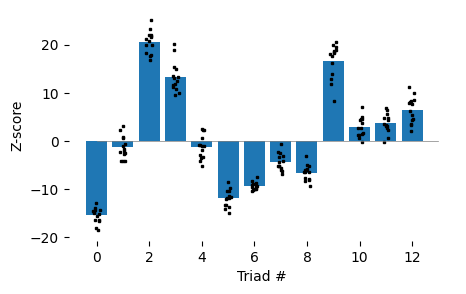

In [7]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.bar(all_counts.columns, all_counts.mean())
x = numpy.repeat(all_counts.columns.values.reshape((1, -1)), len(all_counts), axis=0)
x = x + 0.25 * (numpy.random.rand(*x.shape) - 0.5)
ax.plot(x, all_counts.values, color="black", ls="None", marker='s', ms=2)
ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

Text(0, 0.5, 'Mean distance (um)')

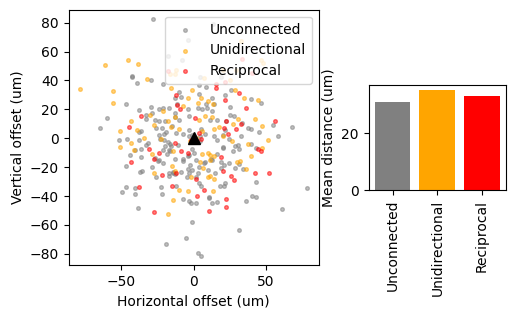

In [8]:
i = 0
d = all_deltas[i]
d = dict([(k, numpy.vstack(v)) for k, v in d.items()])
dists = dict([(k, numpy.linalg.norm(v, axis=1).mean()) for k, v in d.items()])

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])

def sample_random_fraction(arr_in, frac):
    assert frac <= 1
    b = numpy.random.choice(arr_in.shape[0], int(arr_in.shape[0] * frac), replace=False)
    return arr_in[b, 0], arr_in[b, 1]

ax.scatter(*sample_random_fraction(d["unconnected"], 0.1), c="grey", s=7, alpha=0.5, label="Unconnected")
ax.scatter(*sample_random_fraction(d["connected"], 0.1), c="orange", s=7, alpha=0.5, label="Unidirectional")
ax.scatter(*sample_random_fraction(d["reciprocal"], 0.1), c="red", s=7, alpha=0.5, label="Reciprocal")
ax.plot(0, 0, marker="^", ms=8, color="black")
ax.set_xlabel("Horizontal offset (um)")
ax.set_ylabel("Vertical offset (um)")
plt.axis("equal")
plt.legend()

ax = fig.add_axes([0.7, 0.35, 0.275, 0.35])
ax.bar(2, dists["reciprocal"], color="red")
ax.bar(1, dists["connected"], color="orange")
ax.bar(0, dists["unconnected"], color="grey")
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["Unconnected", "Unidirectional", "Reciprocal"], rotation="vertical")
ax.set_ylabel("Mean distance (um)")